# Logistic Regression model with stochastic gradient descent for High-Low Returns classification
**Ferney Beltran**

Based on the post [Naive Bayes High Low Return Prediction Algorithm - German Hernandez](https://github.com/gjhernandezp/ML/blob/master/Naive%20Bayes%20High%20Low%20Return%20Prediction%20Analysis.ipynb) 

This Notebook proposes a **Logisctic regression model with stochastic gradient descent** for the classification of high or low returns in a algo-trading in Quantopian. 
If a stock evidence a positive return in the next **n_fwd_days** after the measured time and coming from the  **top percentile% of returns (class 1)**, then the ML strategy is trained to buy shares of the market. Otherwise it will sell shares of the market. The input variables are the returns for everyone of the past 10 days.

In [2]:
n_fwd_days = 5 # number of days to compute returns over
percentile = 25 # target percetile of the prediction

Using the good quality Quantopian tradable stocks [QTradableStocksUS()](https://www.quantopian.com/posts/working-on-our-best-universe-yet-qtradablestocksus) for a period of time between the **start** and **end** dates.

In [3]:
from quantopian.pipeline.filters import QTradableStocksUS
universe = QTradableStocksUS()

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

start = pd.Timestamp("2018-05-26")
end = pd.Timestamp("2018-09-26")

Using the [Quantopian Pipeline API](https://www.quantopian.com/tutorials/pipeline) it allows to use some preprocessing techniques to construct a dataset.

The **Returns** function from the pipeline is returned because the input variables corresponds to the returns in the past, which depend both on the **n_fwd_days** ahead return.

## Building the train-test dataset

In [4]:
from quantopian.pipeline.factors import Returns

 The function **make_factors()** define other functions, which calculate the dataset's input variables, also called **factors**. These input variables are the previous returns for each one of the last 10 days. 
The Quantopian's function **Returns()** is one of the [Built-in Factors](https://www.quantopian.com/help#module-quantopian_pipeline_factors) in the [Quantopian Pipeline API]. The parameter **window_length** defines the number of days to calculate the return. 

In [5]:
def make_factors():
    def Asset_Growth_1d():
        return Returns(window_length=2)
    def Asset_Growth_2d():
        return Returns(window_length=3)
    def Asset_Growth_3d():
        return Returns(window_length=4)
    def Asset_Growth_4d():
        return Returns(window_length=5)
    def Asset_Growth_5d():
        return Returns(window_length=6)
    def Asset_Growth_6d():
        return Returns(window_length=7)
    def Asset_Growth_7d():
        return Returns(window_length=8)
    def Asset_Growth_8d():
        return Returns(window_length=9)
    def Asset_Growth_9d():
        return Returns(window_length=10)
    def Asset_Growth_10d():
        return Returns(window_length=11) 
    
    
    all_factors = {
        'Asset Growth 1d': Asset_Growth_1d,
        'Asset Growth 2d': Asset_Growth_2d,
        'Asset Growth 3d': Asset_Growth_3d,
        'Asset Growth 4d': Asset_Growth_4d,
        'Asset Growth 5d': Asset_Growth_5d,
        'Asset Growth 6d': Asset_Growth_6d,
        'Asset Growth 7d': Asset_Growth_7d,
        'Asset Growth 8d': Asset_Growth_8d,
        'Asset Growth 9d': Asset_Growth_9d,
        'Asset Growth 10d': Asset_Growth_10d
    }     

    return all_factors

factors = make_factors()

factors

{'Asset Growth 10d': <function __main__.Asset_Growth_10d>,
 'Asset Growth 1d': <function __main__.Asset_Growth_1d>,
 'Asset Growth 2d': <function __main__.Asset_Growth_2d>,
 'Asset Growth 3d': <function __main__.Asset_Growth_3d>,
 'Asset Growth 4d': <function __main__.Asset_Growth_4d>,
 'Asset Growth 5d': <function __main__.Asset_Growth_5d>,
 'Asset Growth 6d': <function __main__.Asset_Growth_6d>,
 'Asset Growth 7d': <function __main__.Asset_Growth_7d>,
 'Asset Growth 8d': <function __main__.Asset_Growth_8d>,
 'Asset Growth 9d': <function __main__.Asset_Growth_9d>}

The **Pipeline** function from the [Quantopian Pipeline API](https://www.quantopian.com/tutorials/pipeline) is imported here to build preprocesing filters from a dictionary of factors names and pointers.

In [6]:
from quantopian.pipeline import Pipeline

Definition of the pipeline through the function **make_history_pipeline()**. This functions defines a filter to build the dataframe with the information of the input and target variables.

In [7]:
from quantopian.pipeline.data.builtin import USEquityPricing


def make_history_pipeline(factors, universe, n_fwd_days=5):
    
    # Build dictionary of factors names and definitions used to calculate the information of the input variables 
    factor_ranks = {name: f() for name, f in factors.iteritems()}
    
    # Add to the dictionary the factor name and definitios used to calculate the information of the target variable
    factor_ranks['Returns'] = Returns(inputs=[USEquityPricing.open],window_length=n_fwd_days)
    
    print factor_ranks
    
    pipe = Pipeline(screen=universe, columns=factor_ranks)
    
    return pipe

history_pipe = make_history_pipeline(factors, universe, n_fwd_days=n_fwd_days)

history_pipe

{'Asset Growth 4d': Returns([EquityPricing.close], 5), 'Asset Growth 5d': Returns([EquityPricing.close], 6), 'Asset Growth 7d': Returns([EquityPricing.close], 8), 'Asset Growth 3d': Returns([EquityPricing.close], 4), 'Returns': Returns([EquityPricing<US>.open], 5), 'Asset Growth 8d': Returns([EquityPricing.close], 9), 'Asset Growth 2d': Returns([EquityPricing.close], 3), 'Asset Growth 9d': Returns([EquityPricing.close], 10), 'Asset Growth 10d': Returns([EquityPricing.close], 11), 'Asset Growth 6d': Returns([EquityPricing.close], 7), 'Asset Growth 1d': Returns([EquityPricing.close], 2)}


The function **run_pipeline** (coming from the [Quantopian Pipeline API](https://www.quantopian.com/tutorials/pipeline)) takes a pipe object, a star_date and end_date as parameters to build the dataframe.

In [8]:
from quantopian.research import run_pipeline

Calling the function **run_pipeline**, whose parameters were previously defined.

In [9]:
from time import time
start_timer = time()
results = run_pipeline(history_pipe, start_date=start, end_date=end)
results.index.names = ['date', 'security']
end_timer = time()
print "Time to run pipeline %.2f secs" % (end_timer - start_timer)

Time to run pipeline 9.54 secs


In [10]:
results.head()

Asset Growth 10d  \
date                      security                              
2018-05-29 00:00:00+00:00 Equity(2 [ARNC])           0.012630   
                          Equity(24 [AAPL])         -0.000053   
                          Equity(41 [ARCB])         -0.002544   
                          Equity(52 [ABM])          -0.038961   
                          Equity(53 [ABMD])          0.057736   

                                             Asset Growth 1d  Asset Growth 2d  \
date                      security                                              
2018-05-29 00:00:00+00:00 Equity(2 [ARNC])         -0.002704        -0.010730   
                          Equity(24 [AAPL])         0.001966         0.000690   
                          Equity(41 [ARCB])        -0.022845        -0.003178   
                          Equity(52 [ABM])          0.000000        -0.005106   
                          Equity(53 [ABMD])        -0.001141        -0.004295   

                                             Asset Growth 3d  Asset Growth 4d  \
date                      security                                              
2018-05-29 00:00:00+00:00 Equity(2 [ARNC])         -0.005930         0.000000   
                          Equity(24 [AAPL])         0.006780         0.005117   
                          Equity(41 [ARCB])        -0.020812        -0.045639   
                          Equity(52 [ABM])         -0.020771        -0.026316   
                          Equity(53 [ABMD])         0.020061         0.039680   

                                             Asset Growth 5d  Asset Growth 6d  \
date                      security                                              
2018-05-29 00:00:00+00:00 Equity(2 [ARNC])          0.019348         0.015419   
                          Equity(24 [AAPL])         0.012293         0.008449   
                          Equity(41 [ARCB])        -0.013627        -0.026887   
                          Equity(52 [ABM])         -0.016818        -0.029065   
                          Equity(53 [ABMD])         0.025263         0.037600   

                                             Asset Growth 7d  Asset Growth 8d  \
date                      security                                              
2018-05-29 00:00:00+00:00 Equity(2 [ARNC])          0.023591         0.025014   
                          Equity(24 [AAPL])         0.002072         0.011370   
                          Equity(41 [ARCB])        -0.020812         0.001597   
                          Equity(52 [ABM])         -0.034676        -0.033719   
                          Equity(53 [ABMD])         0.031597         0.036072   

                                             Asset Growth 9d   Returns  
date                      security                                      
2018-05-29 00:00:00+00:00 Equity(2 [ARNC])          0.005453  0.015969  
                          Equity(24 [AAPL])         0.002179  0.001223  
                          Equity(41 [ARCB])        -0.011555 -0.007254  
                          Equity(52 [ABM])         -0.034995 -0.025109  
                          Equity(53 [ABMD])         0.048895  0.024788

In [11]:
results.tail()

Asset Growth 10d  \
date                      security                                   
2018-09-26 00:00:00+00:00 Equity(51542 [DNLI])            0.150759   
                          Equity(51576 [CASA])           -0.001304   
                          Equity(51580 [NMRK])           -0.078969   
                          Equity(51615 [LILA_K])          0.071142   
                          Equity(51618 [NTR])             0.031267   

                                                  Asset Growth 1d  \
date                      security                                  
2018-09-26 00:00:00+00:00 Equity(51542 [DNLI])           0.020192   
                          Equity(51576 [CASA])          -0.009056   
                          Equity(51580 [NMRK])          -0.036522   
                          Equity(51615 [LILA_K])        -0.004655   
                          Equity(51618 [NTR])            0.014572   

                                                  Asset Growth 2d  \
date                      security                                  
2018-09-26 00:00:00+00:00 Equity(51542 [DNLI])           0.011439   
                          Equity(51576 [CASA])          -0.054904   
                          Equity(51580 [NMRK])          -0.022065   
                          Equity(51615 [LILA_K])        -0.008349   
                          Equity(51618 [NTR])            0.008210   

                                                  Asset Growth 3d  \
date                      security                                  
2018-09-26 00:00:00+00:00 Equity(51542 [DNLI])           0.016284   
                          Equity(51576 [CASA])          -0.061275   
                          Equity(51580 [NMRK])           0.011872   
                          Equity(51615 [LILA_K])        -0.008349   
                          Equity(51618 [NTR])           -0.001730   

                                                  Asset Growth 4d  \
date                      security                                  
2018-09-26 00:00:00+00:00 Equity(51542 [DNLI])           0.038669   
                          Equity(51576 [CASA])          -0.060123   
                          Equity(51580 [NMRK])           0.023084   
                          Equity(51615 [LILA_K])        -0.005119   
                          Equity(51618 [NTR])           -0.015185   

                                                  Asset Growth 5d  \
date                      security                                  
2018-09-26 00:00:00+00:00 Equity(51542 [DNLI])           0.036639   
                          Equity(51576 [CASA])          -0.037688   
                          Equity(51580 [NMRK])           0.004533   
                          Equity(51615 [LILA_K])         0.025912   
                          Equity(51618 [NTR])           -0.011813   

                                                  Asset Growth 6d  \
date                      security                                  
2018-09-26 00:00:00+00:00 Equity(51542 [DNLI])           0.133547   
                          Equity(51576 [CASA])          -0.022336   
                          Equity(51580 [NMRK])          -0.008057   
                          Equity(51615 [LILA_K])         0.045477   
                          Equity(51618 [NTR])           -0.002247   

                                                  Asset Growth 7d  \
date                      security                                  
2018-09-26 00:00:00+00:00 Equity(51542 [DNLI])           0.088205   
                          Equity(51576 [CASA])          -0.030993   
                          Equity(51580 [NMRK])          -0.038194   
                          Equity(51615 [LILA_K])         0.054761   
                          Equity(51618 [NTR])            0.031083   

                                                  Asset Growth 8d  \
date                      security                                  
2018-09-26 00:00:00+00:00 Equity(

Defining the train-test datasets using a 80-20 schema

In [12]:
training = 0.8
results_wo_returns = results.copy()
returns = results_wo_returns.pop('Returns')
Y = returns.unstack().values
X = results_wo_returns.to_panel() 
X = X.swapaxes(2, 0).swapaxes(0, 1).values # (factors, time, stocks) -> (time, stocks, factors)

In [13]:
n_time, n_stocks, n_factors = X.shape
train_size = np.int16(np.round(training * n_time))
X_train_aux, Y_train_aux = X[:train_size, ...], Y[:train_size]
X_test_aux, Y_test_aux = X[(train_size+n_fwd_days):, ...], Y[(train_size+n_fwd_days):]

Checking the number of samples in the training dataset before filtering the NaN values: **(days, stocks, variables)**.

In [14]:
n_time, n_stocks, n_factors = X_train_aux.shape
print X_train_aux.shape, n_time* n_stocks

(68, 2293, 10) 155924


Checking the number of samples in the test dataset before filtering the NaN values: **(days, stocks, variables)**.

In [15]:
n_time, n_stocks, n_factors = X_test_aux.shape
print X_test_aux.shape, n_time* n_stocks

(12, 2293, 10) 27516


The function **shift_recode_mask_data ()** is intended for: 
* shifting factors (input variables - returns) to align these with the future target (return n_fwd_days days ahead).
* transforming the target Y as 1 and -1
* deleting NaN samples
* deleting samples, which does not satisfy the percentile criteria

In [16]:
def shift_recode_mask_data(X, Y, upper_percentile=100-percentile, lower_percentile=percentile, n_fwd_days=1):
    # Shift X to match factors at t to returns at t+n_fwd_days (we want to predict future returns after all)
    shifted_X = np.roll(X, n_fwd_days+1, axis=0)
    
    # Slice off rolled elements
    X = shifted_X[n_fwd_days+1:]
    Y = Y[n_fwd_days+1:]
    
    n_time, n_stocks, n_factors = X.shape
    
    # Look for biggest up and down movers
    upper = np.nanpercentile(Y, upper_percentile, axis=1)[:, np.newaxis]
    lower = np.nanpercentile(Y, lower_percentile, axis=1)[:, np.newaxis]
  
    upper_mask = (Y >= upper)
    lower_mask = (Y <= lower)
    
    mask = upper_mask | lower_mask # This also drops nans
    mask = mask.flatten()
    
    # Only try to predict whether a stock moved up/down relative to other stocks
    Y_binary = np.zeros(n_time * n_stocks)
    Y_binary[upper_mask.flatten()] = 1
    Y_binary[lower_mask.flatten()] = -1
    
    # Flatten X
    X = X.reshape((n_time * n_stocks, n_factors))

    # Drop stocks that did not move much (i.e. are not in the upper_percentile or the lower_percentile )
    X = X[mask]
    Y_binary = Y_binary[mask]
    
    # Drop stocks with nan returns
    masknan=  ~np.isnan(X).any(axis=1)
    X = X[masknan]
    Y_binary = Y_binary[masknan]
    
    return X, Y_binary

In [17]:
X_train, Y_train = shift_recode_mask_data(X_train_aux, Y_train_aux, n_fwd_days=n_fwd_days)
X_test, Y_test = shift_recode_mask_data(X_test_aux, Y_test_aux, n_fwd_days=n_fwd_days, 
                                             lower_percentile=50, 
                                             upper_percentile=50)

Checking the number of samples in both the training and test datasets after the application of the **shift_recode_mask_data()*** function

In [18]:
X_train.shape, X_test.shape

((67493, 10), (13133, 10))

In [19]:
Y_train.shape, Y_test.shape

((67493,), (13133,))

## Visual exploration of data

In [20]:
X = X_train
Y = Y_train

color = [] 
for i in range(len(Y)):
    if Y[i] == 1:
        color.append('green')
    else:
        color.append('red')
        

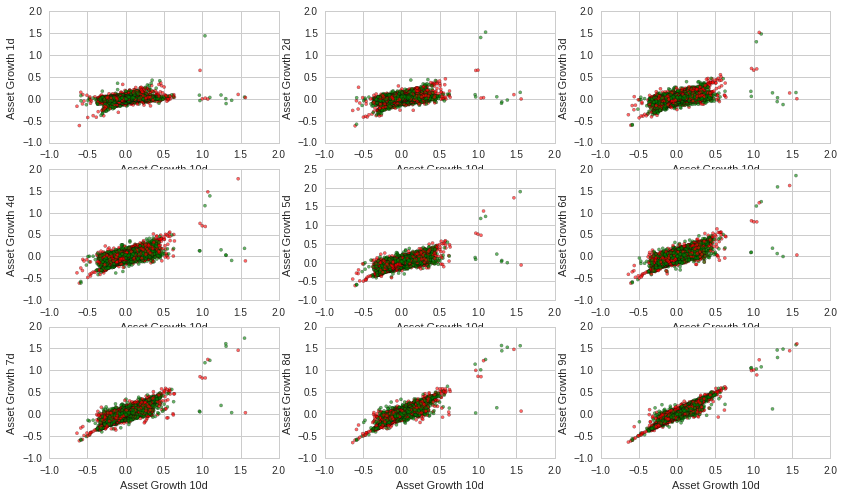

In [21]:
plt.subplot(3, 3, 1)
plt.scatter(X[:, 0], X[:, 1], c=color, alpha= 0.6, s=10, edgecolor='k') 
plt.xlabel('Asset Growth 10d')
plt.ylabel('Asset Growth 1d')

plt.subplot(3, 3, 2)
plt.scatter(X[:, 0], X[:, 2], c=color, alpha= 0.6, s=10, edgecolor='k')  
plt.xlabel('Asset Growth 10d')
plt.ylabel('Asset Growth 2d')

plt.subplot(3, 3, 3)
plt.scatter(X[:, 0], X[:, 3], c=color, alpha= 0.6, s=10, edgecolor='k') 
plt.xlabel('Asset Growth 10d')
plt.ylabel('Asset Growth 3d')

plt.subplot(3, 3, 4)
plt.scatter(X[:, 0], X[:, 4], c=color, alpha= 0.6, s=10, edgecolor='k') 
plt.xlabel('Asset Growth 10d')
plt.ylabel('Asset Growth 4d')

plt.subplot(3, 3, 5)
plt.scatter(X[:, 0], X[:, 5], c=color, alpha= 0.6, s=10, edgecolor='k') 
plt.xlabel('Asset Growth 10d')
plt.ylabel('Asset Growth 5d')

plt.subplot(3, 3, 6)
plt.scatter(X[:, 0], X[:, 6], c=color, alpha= 0.6, s=10, edgecolor='k') 
plt.xlabel('Asset Growth 10d')
plt.ylabel('Asset Growth 6d')

plt.subplot(3, 3, 7)
plt.scatter(X[:, 0], X[:, 7], c=color, alpha= 0.6, s=10, edgecolor='k')  
plt.xlabel('Asset Growth 10d')
plt.ylabel('Asset Growth 7d')

plt.subplot(3, 3, 8)
plt.scatter(X[:, 0], X[:, 8], c=color, alpha= 0.6, s=10, edgecolor='k') 
plt.xlabel('Asset Growth 10d')
plt.ylabel('Asset Growth 8d')

plt.subplot(3, 3, 9)
plt.scatter(X[:, 0], X[:, 9], c=color, alpha= 0.6, s=10, edgecolor='k') 
plt.xlabel('Asset Growth 10d')
plt.ylabel('Asset Growth 9d')

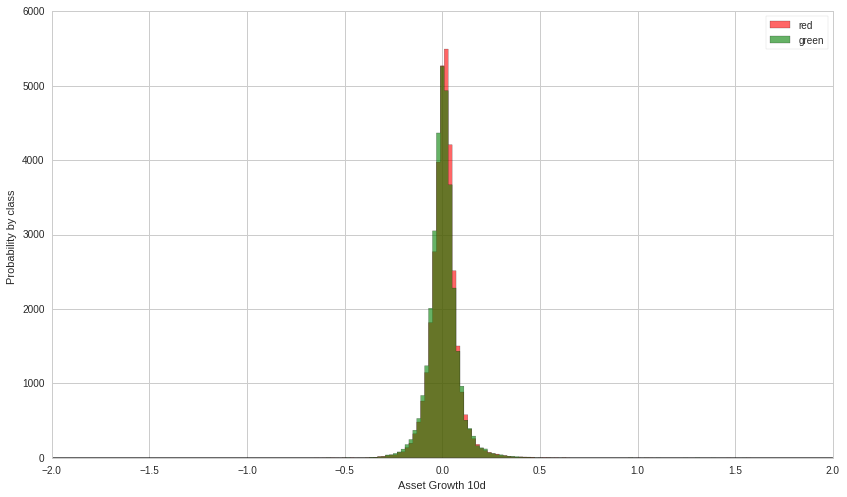

In [22]:
x = X[:,0]

mask = (Y == 1)
xg = x[mask]

mask = (Y == -1)
xr = x[mask]

xlim = (-2, 2)
bins = np.linspace(xlim[0], xlim[1], 200)

plt.hist(xr, bins, alpha=0.6,  histtype='stepfilled', label='red',  color='red')
plt.hist(xg, bins, alpha=0.6,  histtype='stepfilled', label='green', color='green' )
plt.legend(loc='upper right')
plt.xlabel('Asset Growth 10d')
plt.ylabel('Probability by class ')
plt.show()

In [23]:
labels = ['Asset Growth 10d',
          'Asset Growth 1d',
          'Asset Growth 2d',
          'Asset Growth 3d',
          'Asset Growth 4d',
          'Asset Growth 5d',
          'Asset Growth 6d',
          'Asset Growth 7d',
          'Asset Growth 8d',
          'Asset Growth 9d']      
df = pd.DataFrame(X_train, columns=labels)
df['target'] = Y_train
df.sample(20)

,Asset Growth 10d,Asset Growth 1d,Asset Growth 2d,Asset Growth 3d,Asset Growth 4d,Asset Growth 5d,Asset Growth 6d,Asset Growth 7d,Asset Growth 8d,Asset Growth 9d,target
30661,0.033685,0.002309,0.015035,0.032280,0.038632,0.029482,0.049033,0.031579,0.033333,0.028088,1.0
28518,0.037253,0.007775,0.006334,0.008084,0.019667,0.019771,0.016533,0.020191,0.029398,0.028438,-1.0
52015,0.004531,-0.022670,-0.033504,0.000000,0.023747,-0.020202,0.010417,0.024422,0.014379,0.009103,-1.0
52463,-0.075712,-0.001308,0.009521,0.022502,-0.023202,-0.032773,-0.019522,-0.049710,-0.065758,-0.073918,-1.0
26496,-0.119216,0.030496,0.045324,-0.023522,0.003222,0.002299,-0.021549,-0.088266,-0.120815,-0.108407,-1.0
3255,-0.027067,-0.019123,-0.012760,-0.010834,-0.006313,-0.005447,-0.003057,-0.031608,-0.012332,-0.041168,1.0
40464,0.057488,0.095115,0.085782,0.057424,0.048593,0.056843,0.060855,0.041910,0.046440,0.060725,-1.0
64387,0.011703,0.002250,0.011173,0.021697,0.002857,0.001556,-0.000345,0.009235,-0.002583,0.000345,-1.0
8934,0.110092,-0.016260,0.000000,-0.016260,0.016807,0.025424,0.061404,0.130841,0.141509,0.100000,-1.0
2159,-0.036364,0.011450,-0.002737,-0.002737,-0.007828,-0.023451,-0.028981,-0.019509,-0.031722,-0.037318,1.0


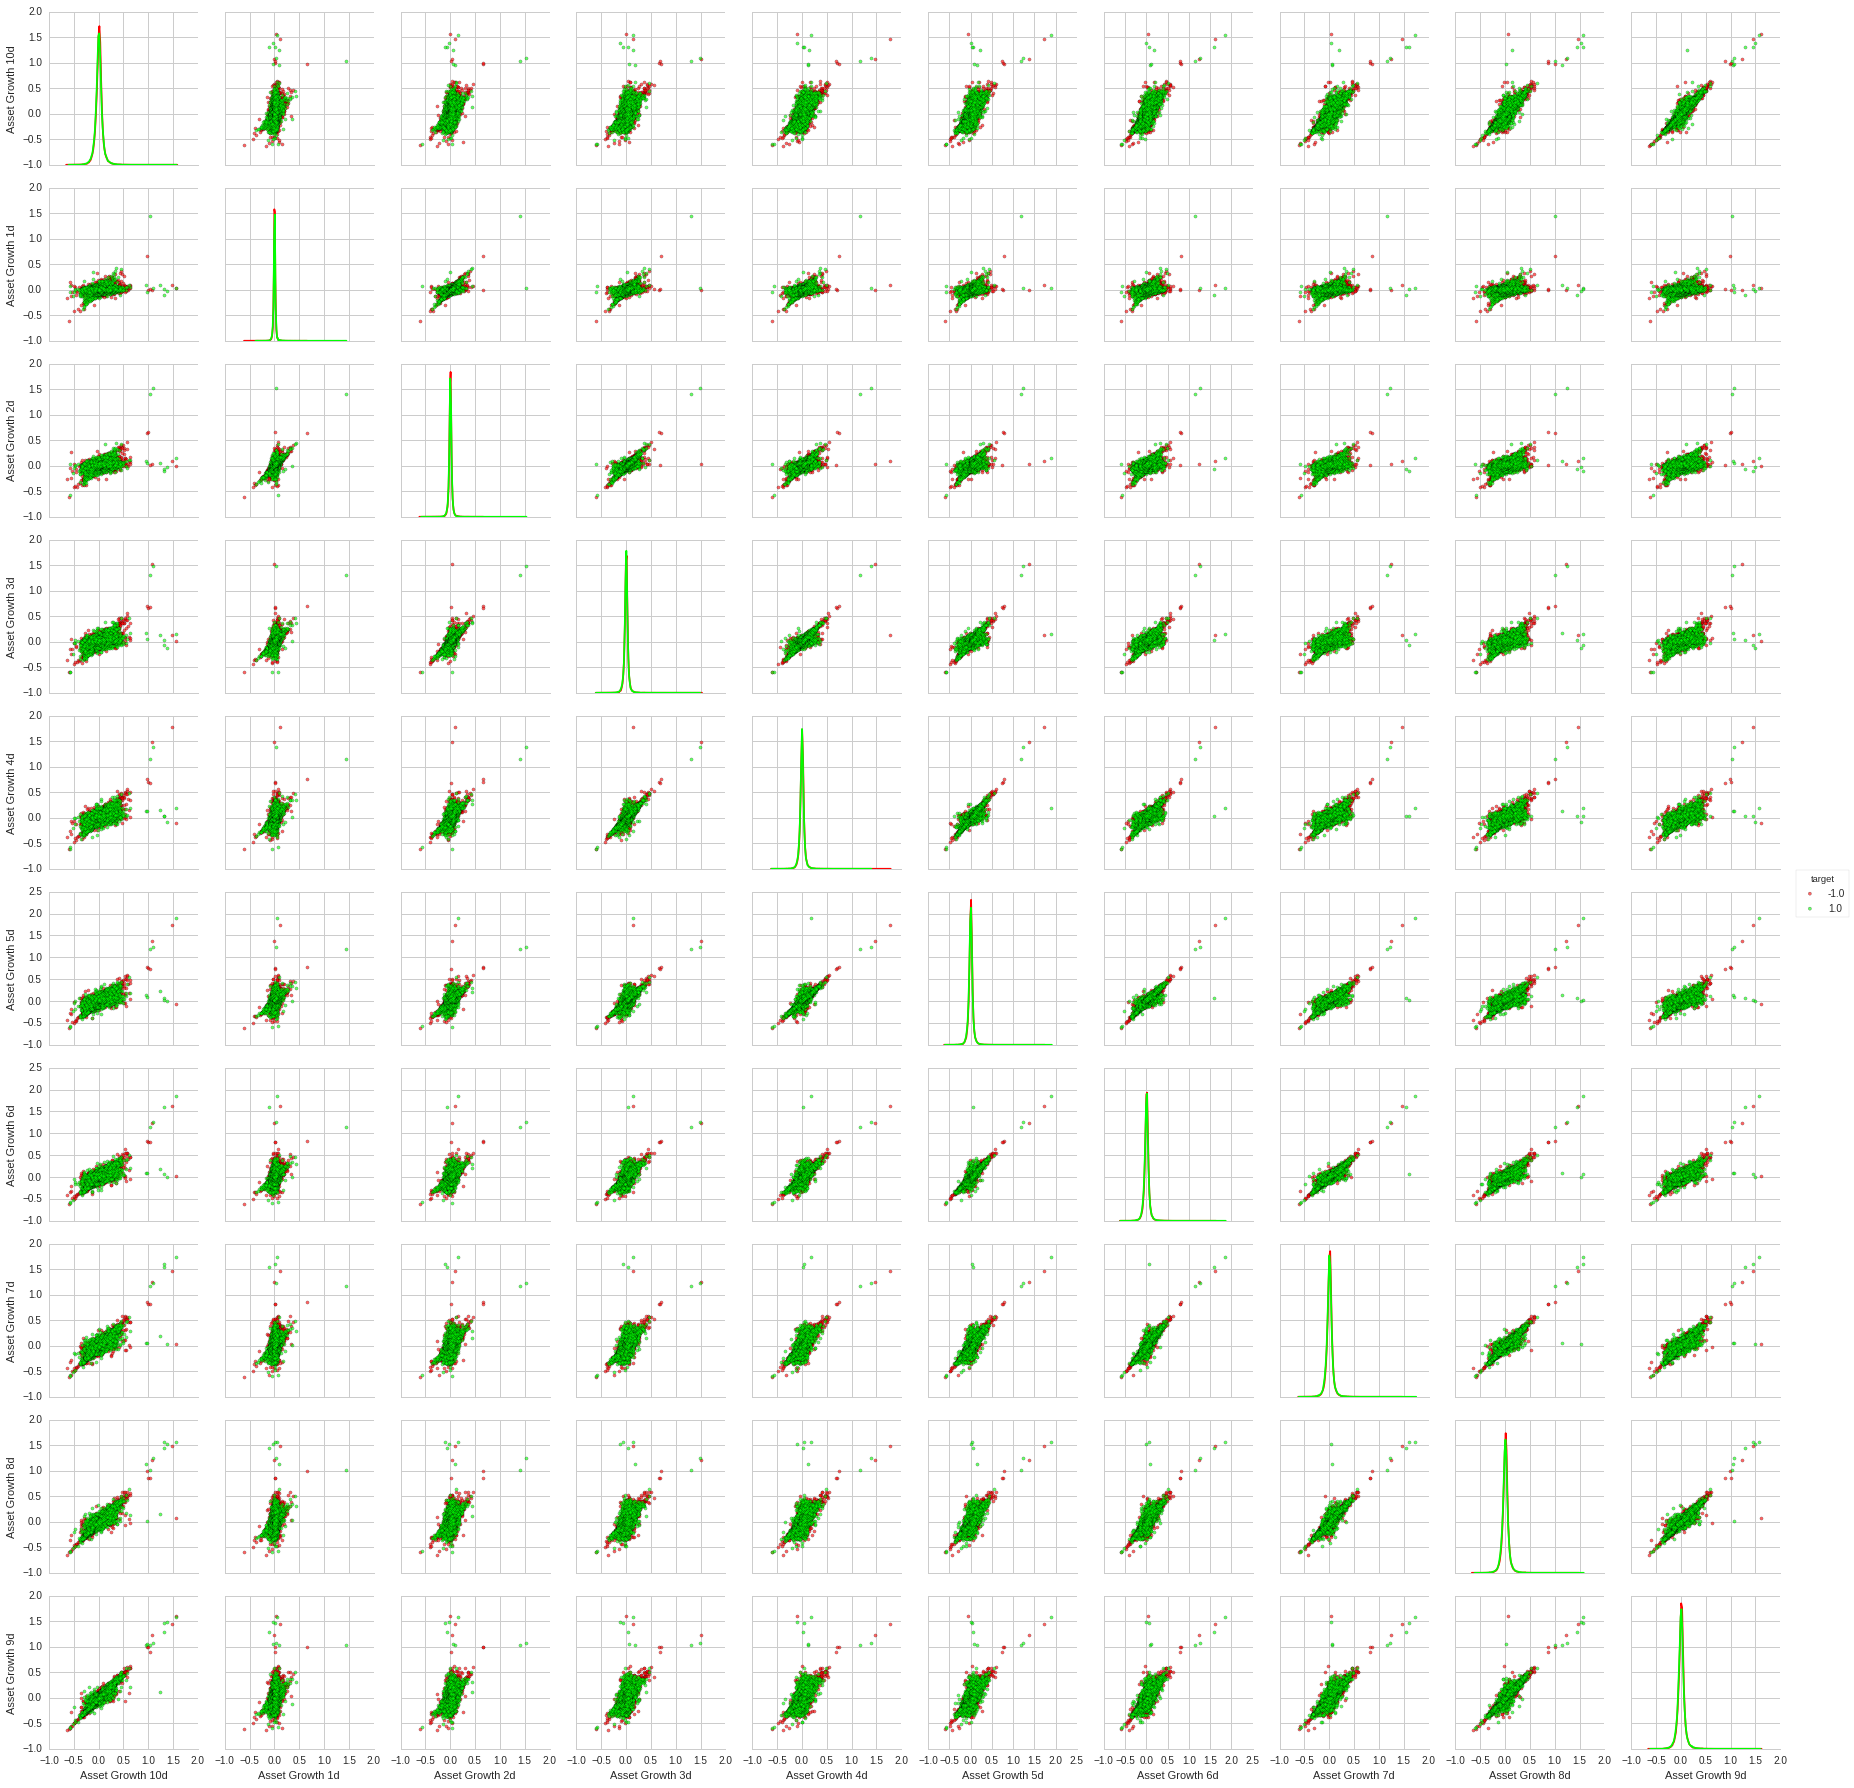

In [24]:
sns.set()
palette = ['#FF0000','#00FF00']
sns.set_palette(palette)
sns.pairplot(df, vars=labels,  hue='target', diag_kind = 'kde', plot_kws = {'alpha': 0.6, 's': 10, 'edgecolor': 'k'});

# Defining a method to evaluate the following ML models

In [25]:
from sklearn import metrics
import numpy as np
from sklearn import linear_model,decomposition, ensemble, preprocessing


def evaluate_model(clf,iterations,X_train,Y_train,X_test,Y_test):
    
    accuracy = np.zeros((iterations,))
    
    for i in range(0,iterations):
        #Fitting the classifier
        clf.fit(X_train, Y_train)

        #Predicting new values
        Y_pred = clf.predict(X_test)
        accuracy[i] = metrics.accuracy_score(Y_test, Y_pred) * 100 
        
    return accuracy

## Train the Gaussian Naive Bayes model

In [26]:
from sklearn.naive_bayes import GaussianNB

#Setting the classifier
clf = GaussianNB()
iterations = 100

start_timer = time()

# Train classifier
accuracy = evaluate_model(clf,iterations,X_train,Y_train,X_test,Y_test)

end_timer = time()

In [27]:
print "Time to train : %0.2f secs" % (end_timer - start_timer)

Time to train : 1.48 secs


In [28]:
# Predict!
Y_pred = clf.predict(X_test)
Y_pred_prob = clf.predict_proba(X_test)

In [29]:
print('Accuracy = %s +/- %s' % (np.mean(accuracy),np.std(accuracy)))
print('Log-loss = {:.5f}'.format(metrics.log_loss(Y_test, Y_pred_prob)))

Accuracy = 53.0267265667 +/- 7.1054273576e-15
Log-loss = 0.71532


In [30]:
print 'Predictions:', Y_pred
print 'Probabilities of class == 1:', Y_pred_prob[:, 1] * 100

Predictions: [-1.  1. -1. ...,  1. -1.  1.]
Probabilities of class == 1: [ 45.89955485  51.58857623  38.23906747 ...,  50.50359791  41.98503051
  77.39720546]


## Train a Logistic Regression model with stochastic gradient descent

In [37]:
from sklearn import linear_model

# Setting the classifier
clf = linear_model.SGDClassifier(loss='log',penalty='l2',alpha=0.3)
iterations = 100

#starting time
start_timer = time()
accuracy = evaluate_model(clf,iterations,X_train,Y_train,X_test,Y_test)
end_timer = time()

In [38]:
print "Time to train : %0.2f secs" % (end_timer - start_timer)

Time to train : 5.41 secs


In [46]:
# Predict!
Y_pred = clf.predict(X_test)

Y_pred_prob = clf.predict_proba(X_test)

In [47]:
print 'Predictions:', Y_pred
print 'Probabilities of class == 1:', Y_pred_prob[:, 1] * 100

Predictions: [-1. -1. -1. ..., -1. -1.  1.]
Probabilities of class == 1: [ 49.96751663  49.97544333  49.92920561 ...,  49.96941056  49.94050567
  50.02159898]


In [48]:
print('Accuracy = %s +/- %s' % (np.mean(accuracy),np.std(accuracy)))
print('Log-loss = {:.5f}'.format(metrics.log_loss(Y_test, Y_pred_prob)))

Accuracy = 50.1637858829 +/- 0.416434242089
Log-loss = 0.69312


In [43]:
print('Accuracy on test set = {:.2f}%'.format(metrics.accuracy_score(Y_test, Y_pred) * 100))
#print('Log-loss = {:.5f}'.format(metrics.log_loss(Y_test, Y_pred_prob)))

Accuracy on test set = 50.64%
